In [1]:
!pip install transformers
!pip install sentencepiece
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
  # Tell PyTorch to use the GPU.    
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

     |████████████████████████████████| 2.1MB 25.4MB/s 
     |████████████████████████████████| 870kB 47.2MB/s 
     |████████████████████████████████| 3.3MB 49.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=296704d09c76ed33e4e251e8543d3ecd9490a27d99db0e06fe65d2d471452144
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 17.7MB/s 
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
import pandas as pd
import sentencepiece as spm
from transformers import BertTokenizer
import numpy as np
df1 = pd.read_csv("/english_train_tweets.csv")#,sep='delimiter',encoding='utf-8')
df2 = pd.read_csv("/english_test_tweets.csv")
frames=[df1,df2]
df=pd.concat(frames)
df.drop_duplicates(subset='id')
# Get the lists of sentences and their labels.
sentences = df.preprocessed.values
df.sentiment[df.sentiment == 'positive'] = 1
df.sentiment[df.sentiment == 'negative'] = 0
df.sentiment[df.sentiment == 'neutral'] = 2
labels = df.sentiment.values
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
max_len = 0
# For every sentence...
for sent in sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  # Update the maximum sentence length.
  max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (988 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1274


In [4]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in sentences:
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict['input_ids'])
  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels=[int(x) for x in labels]
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [5]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create a 90-10 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

40,060 training samples
4,452 validation samples


In [6]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()
# For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
import numpy as np
import time
import datetime
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)
# Function that takes a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))
  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [8]:
import random
import numpy as np
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
# Measure the total training time for the whole run.
total_t0 = time.time()
# For each epoch...
for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================  
  # Perform one full pass over the training set.
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')
  # Measure how long the training epoch takes.
  t0 = time.time()
  # Reset the total loss for this epoch.
  total_train_loss = 0
  # Put the model into training mode. Don't be mislead--the call to 
  # `train` just changes the *mode*, it doesn't *perform* the training.
  # `dropout` and `batchnorm` layers behave differently during training
  # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
  model.train()
  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):
      # Progress update every 40 batches.
      if step % 100 == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)          
          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the GPU using the 
      # `to` method.
      #
      # `batch` contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: labels 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      # Always clear any previously calculated gradients before performing a
      # backward pass. PyTorch doesn't do this automatically because 
      # accumulating the gradients is "convenient while training RNNs". 
      # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
      model.zero_grad()        
      # Perform a forward pass (evaluate the model on this training batch).
      # In PyTorch, calling `model` will in turn call the model's `forward` 
      # function and pass down the arguments. The `forward` function is 
      # documented here: 
      # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
      # The results are returned in a results object, documented here:
      # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
      # Specifically, we'll get the loss (because we provided labels) and the
      # "logits"--the model outputs prior to activation.
      result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
      loss = result.loss
      logits = result.logits
      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. `loss` is a Tensor containing a
      # single value; the `.item()` function just returns the Python value 
      # from the tensor.
      total_train_loss += loss.item()
      # Perform a backward pass to calculate the gradients.
      loss.backward()
      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      # Update parameters and take a step using the computed gradient.
      # The optimizer dictates the "update rule"--how the parameters are
      # modified based on their gradients, the learning rate, etc.
      optimizer.step()
      # Update the learning rate.
      scheduler.step()
  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)            
  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))
  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.
  print("")
  print("Running Validation...")
  t0 = time.time()
  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()
  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the GPU using 
      # the `to` method.
      #
      # `batch` contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: labels 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)  
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        
        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
      # Get the loss and "logits" output by the model. The "logits" are the 
      # output values prior to applying an activation function like the 
      # softmax.
      loss = result.loss
      logits = result.logits      
      # Accumulate the validation loss.
      total_eval_loss += loss.item()
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches.
      total_eval_accuracy += flat_accuracy(logits, label_ids)
  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)  
  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)  
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))
  # Record all statistics from this epoch.
  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
  )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  1,252.    Elapsed: 0:00:35.
  Batch   200  of  1,252.    Elapsed: 0:01:12.
  Batch   300  of  1,252.    Elapsed: 0:01:49.
  Batch   400  of  1,252.    Elapsed: 0:02:26.
  Batch   500  of  1,252.    Elapsed: 0:03:03.
  Batch   600  of  1,252.    Elapsed: 0:03:40.
  Batch   700  of  1,252.    Elapsed: 0:04:16.
  Batch   800  of  1,252.    Elapsed: 0:04:53.
  Batch   900  of  1,252.    Elapsed: 0:05:30.
  Batch 1,000  of  1,252.    Elapsed: 0:06:07.
  Batch 1,100  of  1,252.    Elapsed: 0:06:44.
  Batch 1,200  of  1,252.    Elapsed: 0:07:21.

  Average training loss: 0.75
  Training epcoh took: 0:07:40

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.69
  Validation took: 0:00:18

======== Epoch 2 / 2 ========
Training...
  Batch   100  of  1,252.    Elapsed: 0:00:37.
  Batch   200  of  1,252.    Elapsed: 0:01:14.
  Batch   300  of  1,252.    Elapsed: 0:01:51.
  Batch   400  of  1,252.    Elapsed: 0:02:27.
  Batch  

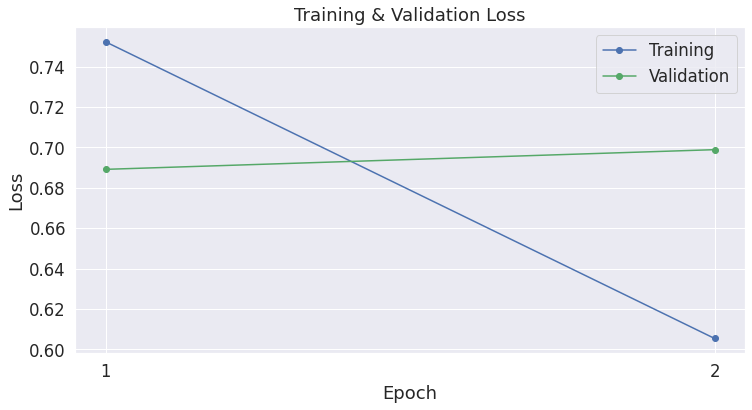

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
# Display floats with two decimal places.
pd.set_option('precision', 2)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
# Display the table.
df_stats
# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])#, 3, 4])
plt.show()

In [11]:
import pandas as pd
import sentencepiece as spm
from transformers import BertTokenizer
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
# Load the dataset into a pandas dataframe.
df=pd.read_csv("/arabic_test.csv",encoding='utf-8')
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
df=df.dropna(subset=['preprocessed'])
# Create sentence and label lists
sentences = df.preprocessed.values
df.sentiment[df.sentiment == 'positive'] = 1
df.sentiment[df.sentiment == 'negative'] = 0
df.sentiment[df.sentiment == 'neutral'] = 2
labels = df.sentiment.values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in sentences:
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict['input_ids'])
    
  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels=[int(x) for x in labels]
labels = torch.tensor(labels)
# Set the batch size.  
batch_size = 32  
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Number of test sentences: 3,355



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [12]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions.
    result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

Predicting labels for 3,338 test sentences...
    DONE.


In [13]:
from sklearn.metrics import accuracy_score
predictions=[item for sublist in predictions for item in sublist]
predictions=[round(torch.softmax(torch.tensor(x),dim=0).numpy()[1]) for x in predictions]
true_labels=[item for sublist in true_labels for item in sublist]
accuracy=accuracy_score(true_labels,predictions)
print(accuracy)

0.34092270820850806
